# __Search Image by Text__

- Tutorial Difficulty: ★★☆☆☆
- 7 min read
- Languages: [SQL](https://en.wikipedia.org/wiki/SQL) (100%)
- File location: tutorial_en/thanosql_search/search_image_by_text.ipynb
- References: [Unsplash Dataset - Lite](https://unsplash.com/data), [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)

## Tutorial Introduction

<div class="admonition note">
    <h4 class="admonition-title">Understanding Vectorizaion</h4>
    <p>For computers to understand human language, it must be vectorized. Recently, studies on pre-built models such as <a href="https://en.wikipedia.org/wiki/BERT_(language_model)">BERT</a> and <a href="https://en.wikipedia.org/wiki/GPT-3">GPT-3</a> have been actively carried out, showing remarkable results. These models identify the meaning of each sentence based on <a href="https://en.wikipedia.org/wiki/Self-supervised_learning">Self-Supervised Learning</a>, and sentences with similar meanings are vectorized and placed close to each other in a low-dimensional space. Self-supervised learning allows learning without labeling by determining whether each sentence/context is true/false. It randomly shuffles the order between sentences or masks some words.</p>
</div>

The handling of different forms of input, such as texts and images, together is called multi-modal. "**CLIP: Connecting Text and Image**" utilizes a multi-modal model to understand low-dimensional vectors. While previous models only trained <a href="https://en.wikipedia.org/wiki/Feature_(machine_learning)">features</a> of the image, the multi-modal model can train both images and texts. It can even learn the features of the texts that describe the images. In addition, by placing texts and images together in a low-dimensional space, the similarity between texts and images can be calculated. From this, a search algorithm can be derived.

ThanoSQL uses machine learning algorithms to vectorize datasets. The vectorized data is stored in a database column, and is used to search for similar images. This can be done by calculating the similarity scores.

__The following are examples and applications of the ThanoSQL text-image search algorithm.__

- Describe the desired scene of an image or video you have with text and search for the image that is the most similar to it. Using text-based descriptions rather than the keywords of a product, search for the most similar product images.
- Search for a timestamp in a Youtube video to place an advertisement in. Easily search for mountain or camping scenes to insert your travel advertisement. 

<div class="admonition note">
    <h4 class="admonition-title">In This Tutorial</h4>
    <p>👉 Unsplash released images taken by more than 200,000 photographers for free to be used as an AI dataset. Unsplash Dataset - Lite consists of 25,000 nature-themed images with 25,000 keywords. </p>
</div>

In this tutorial, we will use the text-image search model to search for images from the Unsplash Dataset - Lite dataset using text.

## __0. Prepare Dataset and Model__

As mentioned in the [ThanoSQL Workspace](https://docs.thanosql.ai/en/getting_started/paas/workspace/lab/), you must create an API token and run the query below to execute the query of ThanoSQL. 

In [ ]:
%load_ext thanosql
%thanosql API_TOKEN=<Issued_API_TOKEN>

### __Prepare Dataset__

In [2]:
%%thanosql
GET THANOSQL DATASET unsplash_data
OPTIONS (overwrite=True)

Success


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>GET THANOSQL DATASET</strong>" downloads the specified dataset to the workspace.</li>
        <li>"<strong>OPTIONS</strong>" specifies the option values to be used for the <strong>GET THANOSQL DATASET</strong> clause.
        <ul>
            <li>"overwrite": determines whether to overwrite a dataset if it already exists. If set as True, the old dataset is replaced with the new dataset (bool, optional, True|False, default: False)</li>
        </ul>
        </li>
    </ul>
</div>

In [3]:
%%thanosql
COPY unsplash_data 
OPTIONS (if_exists='replace')
FROM 'thanosql-dataset/unsplash_data/unsplash.csv'

Success


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>COPY</strong>" specifies the name of the dataset to be saved as a database table.</li>
        <li>"<strong>OPTIONS</strong>" specifies the option values to be used for the <strong>COPY</strong> clause.
        <ul>
           <li>"if_exists": determines how the function should handle the case where the table already exists, it can either raise an error, append to the existing table, or replace the existing table (str, optional, 'fail'|'replace'|'append', default: 'fail')</li>
        </ul>
        </li>
    </ul>
</div>

### __Prepare the Model__

In [4]:
%%thanosql
GET THANOSQL MODEL clip
OPTIONS (
    model_name='tutorial_search_clip',
    overwrite=True
    )

Success


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>GET THANOSQL MODEL</strong>" downloads the specified model to the workspace.</li>
        <li>"<strong>OPTIONS</strong>" specifies the option values to be used for the <strong>GET THANOSQL MODEL</strong> clause.
        <ul>
            <li>"model_name": the model name to store a given model in the ThanoSQL workspace (str, optional)</li>
            <li>"overwrite": determines whether to overwrite a model if it already exists. If set as True, the old model is replaced with the new model (bool, optional, True|False, default: False)</li>
        </ul>
        </li>
    </ul>
</div>

## __1. Check Dataset__

For this tutorial, we use the __unsplash_data__ table located in the ThanoSQL workspace database. Run the query below to check the contents of the table.

In [5]:
%%thanosql
SELECT *
FROM unsplash_data
LIMIT 5

,photo_id,image_path,photo_image_url,photo_description,ai_description
0,XMyPniM9LF0,thanosql-dataset/unsplash_data/XMyPniM9LF0.jpg,https://images.unsplash.com/uploads/1411949294...,Woman exploring a forest,woman walking in the middle of forest
1,rDLBArZUl1c,thanosql-dataset/unsplash_data/rDLBArZUl1c.jpg,https://images.unsplash.com/photo-141633941111...,Succulents in a terrarium,succulent plants in clear glass terrarium
2,cNDGZ2sQ3Bo,thanosql-dataset/unsplash_data/cNDGZ2sQ3Bo.jpg,https://images.unsplash.com/photo-142014251503...,Rural winter mountainside,rocky mountain under gray sky at daytime
3,iuZ_D1eoq9k,thanosql-dataset/unsplash_data/iuZ_D1eoq9k.jpg,https://images.unsplash.com/photo-141487280988...,Poppy seeds and flowers,red common poppy flower selective focus phography
4,BeD3vjQ8SI0,thanosql-dataset/unsplash_data/BeD3vjQ8SI0.jpg,https://images.unsplash.com/photo-141700759404...,Silhouette near dark trees,trees during night time


<div class="admonition note">
    <h4 class="admonition-title">Understanding the Data Table</h4>
    <p>The <strong>unsplash_data</strong> table contains the following information.</p>
    <ul>
        <li>photo_id: unique id column of the image.</li>
        <li>image_path: the name of the column that stores the image path.</li>
        <li>photo_image_url: the name of the column indicating the address of the original image in the unsplash website.</li>
        <li>photo_description: the name of the column that represents a short description of the image.</li>
        <li>ai_description: the name of the column that describes the image generated by AI.</li>
    </ul>
</div>

/home/jovyan/thanosql-dataset/unsplash_data/XMyPniM9LF0.jpg


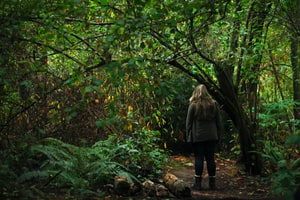

/home/jovyan/thanosql-dataset/unsplash_data/rDLBArZUl1c.jpg


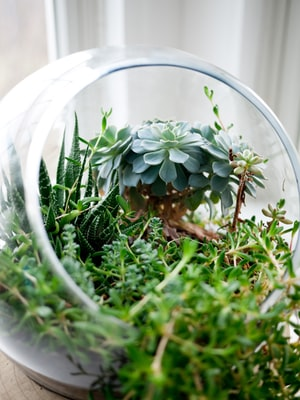

/home/jovyan/thanosql-dataset/unsplash_data/cNDGZ2sQ3Bo.jpg


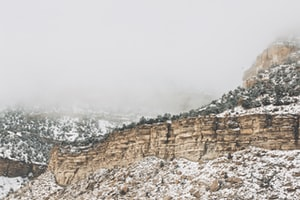

/home/jovyan/thanosql-dataset/unsplash_data/iuZ_D1eoq9k.jpg


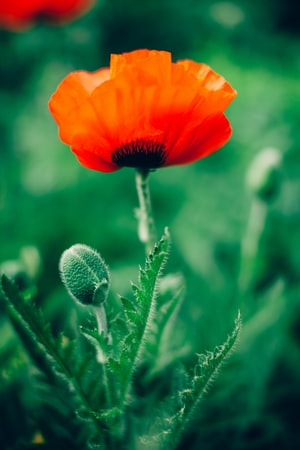

/home/jovyan/thanosql-dataset/unsplash_data/BeD3vjQ8SI0.jpg


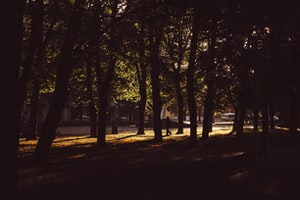

In [6]:
%%thanosql
PRINT IMAGE 
AS
SELECT image_path 
FROM unsplash_data 
LIMIT 5

## __2. Convert Using a Pre-built Model__

<div class="admonition danger">
    <h4 class="admonition-title">Notes</h4>
    <p>Because the text-image algorithm takes a long time to train and since it uses a pre-built model that used 400 million datasets to train, we omit the training process using the "<strong>BUILD MODEL</strong>" query in this tutorial. The <strong>tutorial_search_clip</strong> model named above utilizes a pre-built model that uses <strong>CLIPEn</strong>. When the "<strong>CONVERT USING</strong>" statement is executed, a user-defined column(default: convert_result) containing the vectorized images is created. When the "<strong>SEARCH IMAGE</strong>" statement is executed, a user-defined column(default: search_result) containing the similarities is created.
</p>
</div>

To vectorize the __unsplash_data__ images, run the "__CONVERT USING__" query. Results are stored in the new convert_result column.  
(Estimated duration of query execution: 3 min)

In [7]:
%%thanosql
CONVERT USING tutorial_search_clip
OPTIONS (
    image_col='image_path', 
    convert_type='image',
    batch_size=128,
    result_col='convert_result'
    )
AS 
SELECT *
FROM unsplash_data

,photo_id,image_path,photo_image_url,photo_description,ai_description,convert_result
0,XMyPniM9LF0,thanosql-dataset/unsplash_data/XMyPniM9LF0.jpg,https://images.unsplash.com/uploads/1411949294...,Woman exploring a forest,woman walking in the middle of forest,"[b'\x19', b'c', b'2', b'\xbe', b'\xec', b'#', ..."
1,rDLBArZUl1c,thanosql-dataset/unsplash_data/rDLBArZUl1c.jpg,https://images.unsplash.com/photo-141633941111...,Succulents in a terrarium,succulent plants in clear glass terrarium,"[b'R', b'\xb6', b'\xbe', b'\xbe', b'F', b'?', ..."
2,cNDGZ2sQ3Bo,thanosql-dataset/unsplash_data/cNDGZ2sQ3Bo.jpg,https://images.unsplash.com/photo-142014251503...,Rural winter mountainside,rocky mountain under gray sky at daytime,"[b'\x83', b'\xfe', b'\xb7', b'\xbe', b'b', b'\..."
3,iuZ_D1eoq9k,thanosql-dataset/unsplash_data/iuZ_D1eoq9k.jpg,https://images.unsplash.com/photo-141487280988...,Poppy seeds and flowers,red common poppy flower selective focus phography,"[b'\xd2', b'\xc7', b'\xad', b'<', b'&', b'\x99..."
4,BeD3vjQ8SI0,thanosql-dataset/unsplash_data/BeD3vjQ8SI0.jpg,https://images.unsplash.com/photo-141700759404...,Silhouette near dark trees,trees during night time,"[b'\x96', b'l', b'\x88', b'\xbe', b'\x92', b'9..."
...,...,...,...,...,...,...
24963,c7OrOMxrurA,thanosql-dataset/unsplash_data/c7OrOMxrurA.jpg,https://images.unsplash.com/photo-159300793778...,None,black metal fence during daytime,"[b'\x1c', b'\xa0', b'\t', b'\xbe', b'6', b'\x0..."
24964,15IuQ5a0Qwg,thanosql-dataset/unsplash_data/15IuQ5a0Qwg.jpg,https://images.unsplash.com/photo-159296761254...,Pearl earrings and seashells,white and brown seashell on white surface,"[b'%', b'\x0e', b'\xa1', b'\xbe', b'\x8b', b'\..."
24965,w8nrcXz8pwk,thanosql-dataset/unsplash_data/w8nrcXz8pwk.jpg,https://images.unsplash.com/photo-159299937329...,None,leopard on brown tree trunk during daytime,"[b'-', b'u', b'\x96', b'=', b'\xe4', b'\x92', ..."
24966,n1jHrRhehUI,thanosql-dataset/unsplash_data/n1jHrRhehUI.jpg,https://images.unsplash.com/photo-159192792878...,Floral truck in the streets of Rome,woman in beige coat and white hat standing on ...,"[b'\n', b'\x82', b'b', b'=', b'\xa4', b'V', b'..."


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>CONVERT USING</strong>" uses the <strong>tutorial_search_clip</strong> model as an algorithm for image vectorization.</li>
        <li>"<strong>OPTIONS</strong>" specifies the option values required for image vectorization.
        <ul>
            <li>"image_col": the name of the column containing the image path (str, default: 'image_path')</li>
            <li>"convert_type": file type for vectorization (str, 'image'|'text', default: 'image')</li>
            <li>"batch_size": the size of dataset bundle utilized in a single cycle of training. The larger the number, the better the learning performance. However, considering the size of the memory, only 128 is used in this case (int, optional, default: 16) </li>
            <li>"result_col": defines the column name that contains the vectorized results (str, optional, default: 'convert_result')</li>
        </ul>
        </li>
    </ul>
</div>

## __3. Search__

Perform a text-based image search using the "__SEARCH IMAGE__" query statement and the __tutorial_search_clip__ model created. Execute the following query with the text value of "a black cat" and embedded __unsplash_data__ images to calculate the similarity. The result values are saved into the newly added search_result column.

In [8]:
%%thanosql
SEARCH IMAGE 
USING tutorial_search_clip
OPTIONS (
    search_by='text',
    search_input='a black cat',
    emb_col='convert_result',
    result_col='search_result'
    )
AS 
SELECT * 
FROM unsplash_data

,photo_id,image_path,photo_image_url,photo_description,ai_description,convert_result,search_result
0,UMyfDjQ6Ep8,thanosql-dataset/unsplash_data/UMyfDjQ6Ep8.jpg,https://images.unsplash.com/photo-157712719502...,None,black cat,"[b'\xca', b'\x06', b'\xfe', b'>', b'\xa7', b'\...",0.316566
1,7XJ3d0xK444,thanosql-dataset/unsplash_data/7XJ3d0xK444.jpg,https://images.unsplash.com/photo-157217373317...,None,black cat,"[b'\xbb', b'\x16', b'\x81', b'>', b'd', b'/', ...",0.311922
2,m8HsSWh-y6E,thanosql-dataset/unsplash_data/m8HsSWh-y6E.jpg,https://images.unsplash.com/photo-156855266009...,simon the kitty.,silver tabby cat,"[b'\x84', b'\t', b'\xa1', b'>', b'\x00', b'\xf...",0.310804
3,6ST6S6i9IGM,thanosql-dataset/unsplash_data/6ST6S6i9IGM.jpg,https://images.unsplash.com/photo-1548620848-d...,The cutest black cat to wake up to on a Sunday...,close-up photography of bombay cat,"[b'\xae', b'\xeb', b'x', b'>', b'\x0c', b'\xcb...",0.310139
4,aFyD5aWKu6k,thanosql-dataset/unsplash_data/aFyD5aWKu6k.jpg,https://images.unsplash.com/photo-157850934606...,None,black cat,"[b'\\', b'\xcc', b'V', b'>', b'\x02', b'q', b'...",0.309160
...,...,...,...,...,...,...,...
995,VQ41v-gnd1M,thanosql-dataset/unsplash_data/VQ41v-gnd1M.jpg,https://images.unsplash.com/photo-158956048611...,None,purple smoke in black background,"[b'-', b'\xa6', b'\x15', b'>', b'\x0c', b'\xe1...",0.221915
996,ZAzrYwYS6cM,thanosql-dataset/unsplash_data/ZAzrYwYS6cM.jpg,https://images.unsplash.com/photo-1560048077-c...,None,None,"[b'\x7f', b')', b'-', b'\xbe', b'm', b'^', b'\...",0.221904
997,JibO_kC6vh4,thanosql-dataset/unsplash_data/JibO_kC6vh4.jpg,https://images.unsplash.com/photo-1557434648-e...,None,green cactus close-up photography,"[b'f', b'\xcc', b'\xae', b'=', b'\xff', b'I', ...",0.221892
998,aWcJuh1mUhc,thanosql-dataset/unsplash_data/aWcJuh1mUhc.jpg,https://images.unsplash.com/photo-1544460671-b...,None,brown tabby cat on bed,"[b'>', b'\xab', b'Z', b'>', b'\x84', b'\xeb', ...",0.221883


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>SEARCH IMAGE</strong>" searches for images. Input the text description of the image using the "text" variable. </li>
        <li>"<strong>USING</strong>" specifies <strong>tutorial_search_clip</strong> as the model.</li>
        <li>"<strong>OPTIONS</strong>" specifies the options to be used for image searching.
        <ul>
                <li>"search_by": defines the image|text|audio|video type to be used for the search (str)</li>
                <li>"search_input": defines the input to be used for the search (str)</li>
                <li>"emb_col": the column that contains the vectorized results (str)</li>
                <li>"result_col": defines the name of the column that contains the search results (str, optional, default: 'search_result')</li>
        </ul>
        </li>
    </ul>
</div>

Execute the query below to view the similarity of the five most similar images to 'a black cat'.

In [9]:
%%thanosql
SELECT image_path, search_result 
FROM (
    SEARCH IMAGE 
    USING tutorial_search_clip
    OPTIONS (
        search_by='text',
        search_input='a black cat',
        emb_col='convert_result',
        result_col='search_result',
        top_k=5
        )
    AS 
    SELECT * 
    FROM unsplash_data
    )

,image_path,search_result
0,thanosql-dataset/unsplash_data/UMyfDjQ6Ep8.jpg,0.316566
1,thanosql-dataset/unsplash_data/7XJ3d0xK444.jpg,0.311922
2,thanosql-dataset/unsplash_data/m8HsSWh-y6E.jpg,0.310804
3,thanosql-dataset/unsplash_data/6ST6S6i9IGM.jpg,0.310139
4,thanosql-dataset/unsplash_data/aFyD5aWKu6k.jpg,0.309160


<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <ul>
        <li>"<strong>SEARCH IMAGE</strong>" calculates and returns the similarity between the input text and the image.</li>
        <li>The first "<strong>SELECT</strong>" returns the image_path column and the search_result column from the result nested query.</li>
    </ul>
</div>

To immediately print out the resulting images, nest the previous query with a "__PRINT__" clause. 

/home/jovyan/thanosql-dataset/unsplash_data/UMyfDjQ6Ep8.jpg


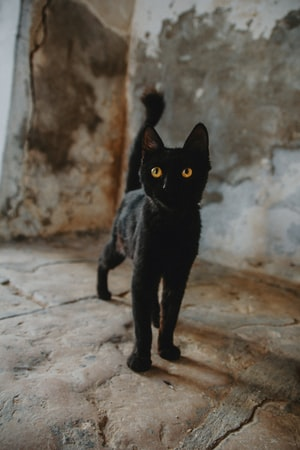

/home/jovyan/thanosql-dataset/unsplash_data/7XJ3d0xK444.jpg


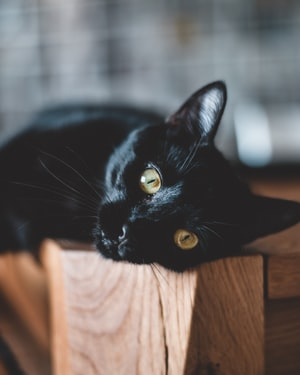

/home/jovyan/thanosql-dataset/unsplash_data/m8HsSWh-y6E.jpg


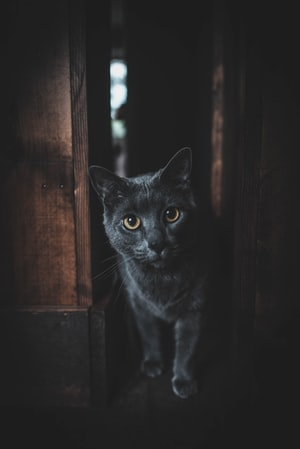

/home/jovyan/thanosql-dataset/unsplash_data/6ST6S6i9IGM.jpg


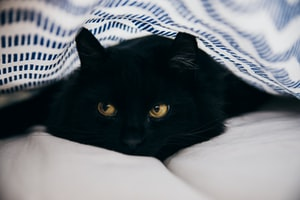

/home/jovyan/thanosql-dataset/unsplash_data/aFyD5aWKu6k.jpg


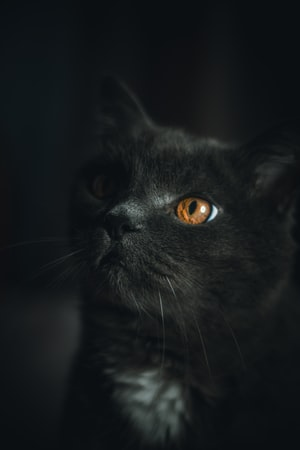

In [10]:
%%thanosql
PRINT IMAGE 
AS (
    SELECT image_path, search_result 
    FROM (
        SEARCH IMAGE 
        USING tutorial_search_clip
        OPTIONS (
            search_by='text',
            search_input='a black cat',
            emb_col='convert_result',
            result_col='search_result',
            top_k=5
            )
        AS 
        SELECT * 
        FROM unsplash_data
        )
    )

<div class="admonition note">
    <h4 class="admonition-title">Query Details</h4>
    <p>This query, combined with the query above, is made of three levels.</p>
    <ul>
        <li>"<strong>SELECT</strong>", in the first parentheses, produces the result of the step immediately above.</li>
        <li>"<strong>PRINT IMAGE</strong>" prints the results of the query as images.</li>
    </ul>
</div>

/home/jovyan/thanosql-dataset/unsplash_data/jZUr3AuI8io.jpg


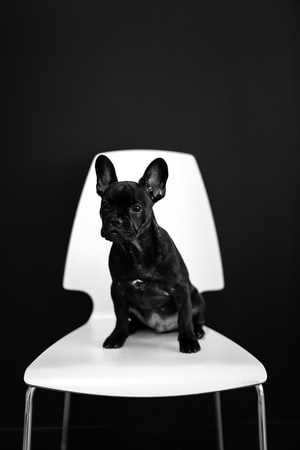

/home/jovyan/thanosql-dataset/unsplash_data/nnKBZTWzlMQ.jpg


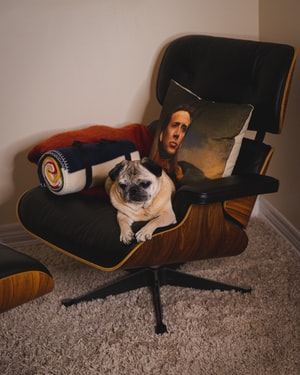

/home/jovyan/thanosql-dataset/unsplash_data/HG2KpOO0vSc.jpg


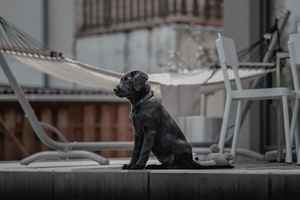

/home/jovyan/thanosql-dataset/unsplash_data/f6qFneRNwNI.jpg


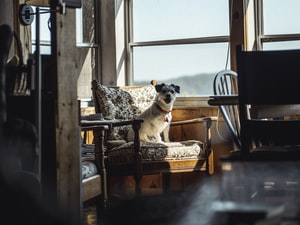

/home/jovyan/thanosql-dataset/unsplash_data/GKY4WDO3QgY.jpg


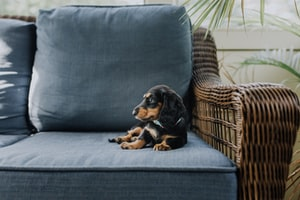

In [11]:
%%thanosql
PRINT IMAGE 
AS (
    SELECT image_path, search_result 
    FROM (
        SEARCH IMAGE 
        USING tutorial_search_clip
        OPTIONS (
            search_by='text',
            search_input='a dog on a chair',
            emb_col='convert_result',
            result_col='search_result',
            top_k=5
            )
        AS 
        SELECT * 
        FROM unsplash_data
        )
    )

/home/jovyan/thanosql-dataset/unsplash_data/Xo4vJrtrmmA.jpg


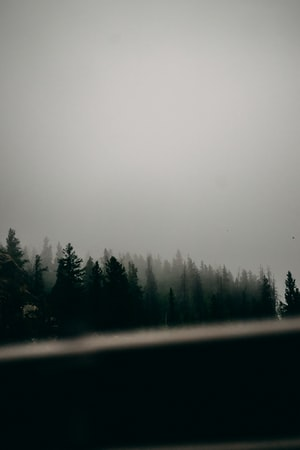

/home/jovyan/thanosql-dataset/unsplash_data/QheWOfwEUio.jpg


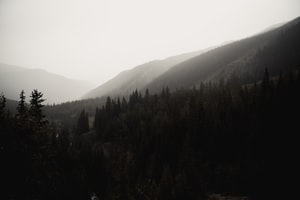

/home/jovyan/thanosql-dataset/unsplash_data/_zHYUQmWrzk.jpg


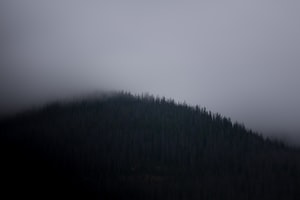

/home/jovyan/thanosql-dataset/unsplash_data/Tu_lH5CFFZw.jpg


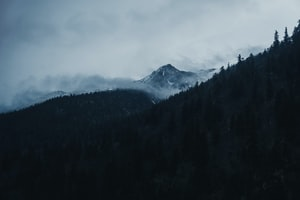

/home/jovyan/thanosql-dataset/unsplash_data/DfYPBHaOR04.jpg


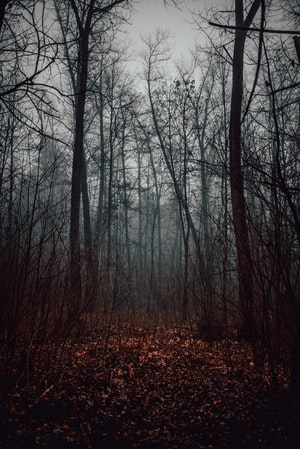

In [12]:
%%thanosql
PRINT IMAGE 
AS (
    SELECT image_path, search_result 
    FROM (
        SEARCH IMAGE 
        USING tutorial_search_clip
        OPTIONS (
            search_by='text',
            search_input='gloomy photos',
            emb_col='convert_result',
            result_col='search_result',
            top_k=5
            )
        AS 
        SELECT * 
        FROM unsplash_data
        )
    )

/home/jovyan/thanosql-dataset/unsplash_data/nDLYtRqJtMw.jpg


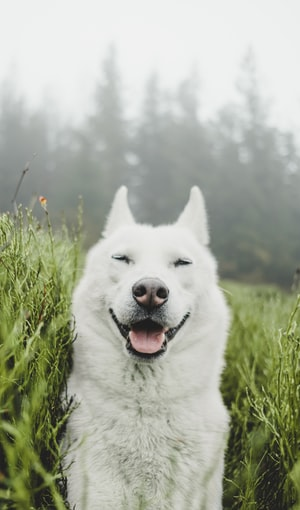

/home/jovyan/thanosql-dataset/unsplash_data/qNJpGSCv_Jc.jpg


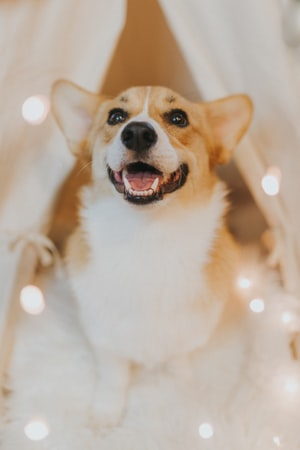

/home/jovyan/thanosql-dataset/unsplash_data/Yb5OBk-OxJY.jpg


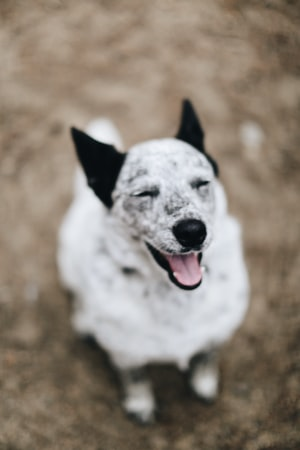

/home/jovyan/thanosql-dataset/unsplash_data/6etH6346MHE.jpg


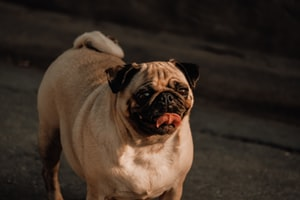

/home/jovyan/thanosql-dataset/unsplash_data/7GX5aICb5i4.jpg


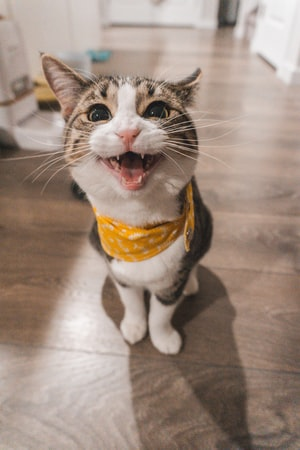

In [13]:
%%thanosql
PRINT IMAGE 
AS (
    SELECT image_path, search_result 
    FROM (
        SEARCH IMAGE 
        USING tutorial_search_clip
        OPTIONS (
            search_by='text',
            search_input='the feeling when your program finally works',
            emb_col='convert_result',
            result_col='search_result',
            top_k=5
            )
        AS 
        SELECT * 
        FROM unsplash_data
        )
    )

## __4. In Conclusion__

In this tutorial, we searched for images in the unsplash dataset by text using a multi-modal text/image vectorization model. As this is a beginner-level tutorial, we focused on the process and showing visible results rather than accuracy. The image search can retrieve more accurate results by utilizing various queries.

* [How to Upload My Data to the ThanoSQL Workspace](https://docs.thanosql.ai/en/getting_started/data_upload/)
* [How to Create a Table Using My Data](https://docs.thanosql.ai/en/how-to_guides/ThanoSQL_query/COPY_SYNTAX/)
* [How to Upload My Model to the ThanoSQL Workspace](https://docs.thanosql.ai/en/how-to_guides/ThanoSQL_query/UPLOAD_MODEL_SYNTAX/)

<div class="admonition tip">
    <h4 class="admonition-title">Inquiries About Deploying a Model for Your Own Service</h4>
    <p>If you have any difficulties creating your own model using ThanoSQL or applying it to your services, please feel free to contact us below😊</p>
    <p>For inquiries regarding building a text-image search models: <a href="mailto:contact@smartmind.team">contact@smartmind.team</a></p>
</div>